In [1]:
import json
import pandas as pd

from datetime import timedelta
from sklearn.metrics import accuracy_score, f1_score

from snowflake.core.task.context import TaskContext
from snowflake.core import Root
from snowflake.core.task.dagv1 import DAGOperation, DAG, DAGTask, DAGTaskBranch

from snowflake.ml.modeling import preprocessing
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.registry import registry
from snowflake.ml.utils.connection_params import SnowflakeLoginOptions
from snowflake.snowpark import Session
from snowflake.snowpark import functions

In [2]:
_MODEL_REGISTRY_DB = 'MODEL_REGISTRY'
_MODEL_REGISTRY_SCHEMA = 'MODEL_SCHEMA'
_MODEL_NAME = 'FRAUD_DETECTION_XGB'

DB_NAME = 'DAG_RUNS'
SCHEMA_NAME = 'SCHEDULED_RUNS'
WAREHOUSE = 'MY_WH'
ROLE = 'TPCXAI'

In [3]:
label_column_name = ["ISFRAUD"]
output_cols=["PRED"]
feature_column_names = ["TX_UTILIZATION_NORM", "TX_DAILY_COUNT_NORM", "PREF_CUSTOMER", "HOUR_OF_DAY"]

In [4]:
def construct_df(session: Session, start_time, end_time):
    DATA_DB = "TPCXAI_SF0003_INC"
    DATA_SCHEMA = "TRAINING"
    accts = session.table(f"{DATA_DB}.{DATA_SCHEMA}.FINANCIAL_ACCOUNT")
    transactions = session.table(f"{DATA_DB}.{DATA_SCHEMA}.FINANCIAL_TRANSACTIONS").filter(
        (functions.col("TIME") >= start_time) & (functions.col("TIME") < end_time))
    
    
    accts = accts.with_column("CUSTOMER_ID", functions.call_builtin("TO_VARCHAR", accts['FA_CUSTOMER_SK']))
    
    transactions = transactions.with_column("HOUR_OF_DAY", functions.hour(functions.col("TIME"))) \
                            .with_column("DATE", functions.to_date(functions.col("TIME")))
    transaction_with_accounts = transactions.join(accts, transactions['SENDERID'] == accts['CUSTOMER_ID'], how='outer', rsuffix='_SENDER') \
                                        .join(accts, transactions['RECIEVERID'] == accts['CUSTOMER_ID'], how='outer', rsuffix='_RECEIVER')
    customers = session.table(f"{DATA_DB}.{DATA_SCHEMA}.CUSTOMER")
    transaction_with_customers = transaction_with_accounts.join(customers, transaction_with_accounts["SENDERID"] == customers["C_CUSTOMER_SK"], how='left') \
                                        .with_column("PERCENT_TRANSACTION_LIMIT", functions.col("AMOUNT")/functions.col("TRANSACTION_LIMIT"))
    daily_transactions = transactions.group_by(["DATE", "SENDERID"]).count().sort(functions.col("COUNT"), ascending=False)
    final_transactions = transaction_with_customers.join(daily_transactions, (transaction_with_customers["SENDERID"] == daily_transactions["SENDERID"]) & (transaction_with_customers["DATE"] == daily_transactions["DATE"]), rsuffix="_TX") \
                                    .with_column_renamed("COUNT", "TX_DAILY_COUNT")
    return final_transactions

def fit_scaler(session: Session, df):
    mm_target_columns = ["PERCENT_TRANSACTION_LIMIT", "TX_DAILY_COUNT"]
    mm_target_cols_out = ["TX_UTILIZATION_NORM", "TX_DAILY_COUNT_NORM"]
    snowml_mms = preprocessing.MinMaxScaler(input_cols=mm_target_columns, output_cols=mm_target_cols_out)
    snowml_mms.fit(df)
    return snowml_mms

def fit_ohe(session, df):
    target_cols = ["C_BIRTH_COUNTRY"]
    output_cols = ["C_BIRTH_COUNTRY_OHE"]
    snowml_ohe = preprocessing.OneHotEncoder(input_cols=target_cols, output_cols=output_cols)
    snowml_ohe.fit(df)
    return snowml_ohe

def clean_up_ohe_columns(df, snowml_ohe):
    #import unicodedata
    ohe_columns = snowml_ohe.get_output_cols()
    #print(f"OLD Column Names: {', '.join(ohe_columns)}")
    final_columns = []
    i = 0
    for x in ohe_columns:
        try:
            #x1 = unicodedata.normalize('NFD', u'{}'.format(x).encode('UTF-8', errors='ignore').decode(errors='ignore').replace("\'", "").replace(',', '').replace(' ', '_').replace('.', '').replace('-', '_'))
            x1 = x.replace("\'", "").replace(',', '').replace(' ', '_').replace('.', '').replace('-', '_')
            final_columns.append(x1)
        except:
            print(f"Failed to convert '{x}'")
            i = i + 1
            final_columns.append(f"NON_CONFORMING_COL_{i}")
    #print(f"New Column Names: {', '.join(final_columns)}")
    column_map = dict(zip(ohe_columns, final_columns))
    for k,v in column_map.items():
        df = df.with_column_renamed(k, v)
        #print(f"NEW Column Names: {', '.join(final_columns)}")
    return df

In [5]:
def get_version_name(runid):
    return f"v{runid}"

def log_model(session: Session, model, test_df, feature_column_names, version_name):
    model_tags = {"stage": "testing", "classifier_type": "RandomForestClassifier"}
    sample_intput_pdf = test_df.select(feature_column_names).to_pandas()
    print(f"Registering model '{_MODEL_NAME}' with version: '{version_name}'")
    reg = registry.Registry(session=session, database_name=_MODEL_REGISTRY_DB, schema_name=_MODEL_REGISTRY_SCHEMA)
    mv = reg.log_model(model, model_name=_MODEL_NAME, version_name=version_name, sample_input_data=sample_intput_pdf)

In [6]:
# Task 1: Setup Task
def setup(session: Session) -> str:
    # Get db_name from the DAG config set at DAG level.
    ctx = TaskContext(session)
    db_name = ctx.get_task_graph_config_property('DB_NAME')

    # Setup rest of the constant for the DAG from start timestamp.
    start_timestamp = ctx.get_runtime_info('CURRENT_TASK_GRAPH_ORIGINAL_SCHEDULED_TIMESTAMP')
    runid = start_timestamp.strftime('%Y%m%d%H%M')
    #RUN_ID = datetime.today().strftime('%Y%m%d%H%M')
    END_TIME = start_timestamp.strftime('%Y-%m-%d %H:%M:00')
    #END_TIME = datetime.today().strftime('%Y-%m-%d %H:%M:00')
    START_TIME = (start_timestamp - timedelta(days=7)).strftime('%Y-%m-%d %H:%M:00')
    schema = f"RUN_{runid}"

    session.sql(f"CREATE SCHEMA IF NOT EXISTS {db_name}.{schema};").collect()

    setup_data = {'start_time': START_TIME, 'end_time': END_TIME, 'db': db_name, 'schema': schema, 'version_name': get_version_name(runid)}
    setup_data_str = json.dumps(setup_data)
    return setup_data_str


In [7]:
# Task 2
def feature_eng(session: Session) -> str:
    ctx = TaskContext(session)
    setup_data_str = ctx.get_predecessor_return_value("SETUP")

    setup_obj = json.loads(setup_data_str)
    assert 'db' in setup_obj and setup_obj['db']
    db = setup_obj['db']
    assert 'schema' in setup_obj and setup_obj['schema']
    schema = setup_obj['schema']
    assert 'start_time' in setup_obj and setup_obj['start_time']
    start_time = setup_obj['start_time']
    assert 'end_time' in setup_obj and setup_obj['end_time']
    end_time = setup_obj['end_time']
    print(f"{setup_obj}")

    final_transactions = construct_df(session, start_time, end_time)
    snowml_mms = fit_scaler(session, final_transactions)
    normed_df = snowml_mms.transform(final_transactions)
    normed_df = normed_df.with_column("PREF_CUSTOMER", functions.when(normed_df['C_PREFERRED_CUST_FLAG']=='Y', functions.lit(1)).otherwise(functions.lit(0)))
    snowml_ohe = fit_ohe(session, normed_df)
    ohe_df = snowml_ohe.transform(normed_df)
    final_df = clean_up_ohe_columns(ohe_df, snowml_ohe)
    final_df_table = f"{db}.{schema}.final_data"
    final_df.write.mode("overwrite").save_as_table(final_df_table)

    print(f"Feature Engineering done. Final table: {final_df_table}")
    return final_df_table

In [8]:
# Task 3
def split_data(session: Session) -> str:
    ctx = TaskContext(session)
    setup_data_str = ctx.get_predecessor_return_value("SETUP")
    data_table_name = ctx.get_predecessor_return_value("FEATURE_ENG")
    
    setup_obj = json.loads(setup_data_str)
    assert 'db' in setup_obj and setup_obj['db'], 'db not found in setup config'
    db = setup_obj['db']
    assert 'schema' in setup_obj and setup_obj['schema'], 'schema is not in setup config'
    schema = setup_obj['schema']

    final_df = session.table(data_table_name)
    input_df = final_df.select([*label_column_name, *feature_column_names])
    train_df, test_df = input_df.random_split(weights=[0.8, 0.2], seed=42)

    train_df_table = f"{db}.{schema}.{ctx.get_task_graph_config_property('training_data_table_name')}"
    test_df_table = f"{db}.{schema}.{ctx.get_task_graph_config_property('test_data_table_name')}"

    train_df.write.mode("overwrite").save_as_table(train_df_table)
    test_df.write.mode("overwrite").save_as_table(test_df_table)

    split_data = {'training_data_table': train_df_table, 'test_data_table': test_df_table}
    split_data_str = json.dumps(split_data)
    #print(f"Split done. Final result: {split_data_str}")
    return split_data_str

In [9]:
# Task 4
def train(session: Session) -> None:
    ctx = TaskContext(session)
    setup_data_str = ctx.get_predecessor_return_value("SETUP")
    split_data_str = ctx.get_predecessor_return_value("SPLIT_DATA")

    setup_data = json.loads(setup_data_str)
    assert 'version_name' in setup_data and setup_data['version_name'], 'version_name not in setup_data'
    version_name = setup_data['version_name']

    split_data = json.loads(split_data_str)
    assert 'training_data_table' in split_data and split_data['training_data_table'], 'training_data_stable not in split_data'
    training_data_table = split_data['training_data_table']

    train_df = session.table(training_data_table)
    model = XGBClassifier(input_cols=feature_column_names, label_cols=label_column_name, output_cols=output_cols)
    model.fit(train_df)
    log_model(session, model, train_df, feature_column_names, version_name)

In [10]:
# Task 5
def evaluate(session: Session) -> float:
    ctx = TaskContext(session)
    setup_data_str = ctx.get_predecessor_return_value("SETUP")
    split_data_str = ctx.get_predecessor_return_value("SPLIT_DATA")

    setup_data = json.loads(setup_data_str)
    assert 'version_name' in setup_data and setup_data['version_name'], 'version_name not in setup_data'
    version_name = setup_data['version_name']

    split_data = json.loads(split_data_str)
    assert 'test_data_table' in split_data and split_data['test_data_table'], 'test_data_table not in split_data'
    test_data_table = split_data['test_data_table']
    test_df = session.table(test_data_table)
    reg = registry.Registry(session=session, database_name=_MODEL_REGISTRY_DB, schema_name=_MODEL_REGISTRY_SCHEMA)
    model_version = reg.get_model(_MODEL_NAME).version(version_name)
    result = model_version.run(test_df, function_name="predict").select("ISFRAUD", "PRED").to_pandas()

    assert 'db' in setup_data and setup_data['db'], 'db not found in setup config'
    db = setup_data['db']
    assert 'schema' in setup_data and setup_data['schema'], 'schema is not in setup config'
    schema = setup_data['schema']

    pred_v_actuals =  result[["ISFRAUD", "PRED"]]
    pred_v_actuals['PRED'] = pd.to_numeric(pred_v_actuals.PRED)
    accuracy = accuracy_score(pred_v_actuals["ISFRAUD"], pred_v_actuals["PRED"])
    f1 = f1_score(pred_v_actuals["ISFRAUD"], pred_v_actuals["PRED"])
    model_version.set_metric(metric_name='f1', value=f1)
    model_version.set_metric(metric_name='accuracy', value=accuracy)
    print("Accuracy: {}".format(accuracy))
    print("F1 Score: {}".format(f1))
    return accuracy

In [11]:
# Task 5b: Branch on 5
def should_push_to_prod(session: Session) -> str:
    ctx = TaskContext(session)
    acc_str = ctx.get_predecessor_return_value("EVALUATE")
    accuracy = float(acc_str)
    if accuracy > 0.99:
        return 'mark_model_golden'
    else:
        return 'cleanup'

In [12]:
# Task 6
def mark_model_golden(session: Session) -> None:
    ctx = TaskContext(session)
    setup_data_str = ctx.get_predecessor_return_value("SETUP")
    setup_data = json.loads(setup_data_str)
    assert 'version_name' in setup_data and setup_data['version_name'], 'version_name not in setup_data'
    version_name = setup_data['version_name']
    reg = registry.Registry(session=session, database_name=_MODEL_REGISTRY_DB, schema_name=_MODEL_REGISTRY_SCHEMA)
    reg.get_model(_MODEL_NAME).default = version_name
    print(f"Marked the model golden: Model Name={_MODEL_NAME} version={version_name}")

In [13]:
# Task 7
def cleanup(session: Session) -> None:
    ctx = TaskContext(session)
    setup_data_str = ctx.get_predecessor_return_value("SETUP")
    setup_data = json.loads(setup_data_str)
    assert 'db' in setup_data and setup_data['db'], 'db is not in setup_data'
    db = setup_data['db']
    assert 'schema' in setup_data and setup_data['schema'], 'schema is not in setup_data'
    schema = setup_data['schema']

    print(f"Dropping workspace schema: {db}.{schema}")
    session.sql(f"DROP SCHEMA {db}.{schema};").collect()

In [14]:
session = Session.builder.configs(SnowflakeLoginOptions("akdefault")).create()
session.use_database(DB_NAME)
session.use_schema(SCHEMA_NAME)
session.use_role(ROLE)
session.use_warehouse(WAREHOUSE)

SnowflakeLoginOptions() is in private preview since 0.2.0. Do not use it in production. 


In [16]:
api_root = Root(session)
schema = api_root.databases[DB_NAME].schemas[SCHEMA_NAME]
STAGE_LOCATION=f"@{DB_NAME}.{SCHEMA_NAME}.SPROC_STAGE"

dag = DAG("daily_training",
          schedule=timedelta(days=1),
          use_func_return_value=True,
          warehouse=WAREHOUSE,
          stage_location=f"{STAGE_LOCATION}",
          packages=["snowflake-snowpark-python", "snowflake-ml-python", "xgboost"],
          config={'DB_NAME': DB_NAME, 'training_data_table_name': 'training_data', 'test_data_table_name': 'training_data'},
          )
with dag:
    setup_task = DAGTask("setup", definition=setup)
    condition = DAGTaskBranch("condition", definition=should_push_to_prod)
    mark_model_golden_task = DAGTask("mark_model_golden", definition=mark_model_golden)
    cleanup_task = DAGTask("cleanup_task", definition=cleanup)

    # TODO: Add cleanup as Finalizer when ready.
    setup_task >> feature_eng >> split_data >> train >> evaluate >> condition >> [mark_model_golden_task, cleanup]
    mark_model_golden_task >> cleanup_task

dag_op = DAGOperation(schema)
dag_op.deploy(dag, mode="orReplace")
dag_op.run(dag)

In [16]:
current_runs = dag_op.get_current_dag_runs(dag)
for r in current_runs:
    print(f"RunId={r.run_id} State={r.state}")

RunId=1707202373528 State=SCHEDULED


In [17]:
all_runs = dag_op.get_complete_dag_runs(dag)
for r in all_runs:
    print(f"RunId={r.run_id} State={r.state} FailedAt={r.first_error_task_name} with message={r.first_error_message}")

RunId=1707197297348 State=FAILED FailedAt=DAILY_TRAINING$FEATURE_ENG with message=Python Interpreter Error:
Traceback (most recent call last):
  File "/home/udf/201940217/udf_py_185461421.zip/udf_py_185461421.py", line 121, in compute
    return func(session)
  File "/Users/sdas/miniconda3/envs/snowml2/lib/python3.8/site-packages/snowflake/core/task/dagv1.py", line 112, in wrapper
  File "/var/folders/dh/qh_2h6s518717s2kw0vjshf80000gn/T/ipykernel_1211/1734510799.py", line 4, in feature_eng
  File "/home/udf/201940217/context.py.zip/snowflake/core/task/context.py", line 85, in get_predecessor_return_value
    return str(self._session.call("system$get_predecessor_return_value", task_name))
  File "/usr/lib/python_udf/360b9b25f78ea23a2c6dfcff010ed349d52d80f0c225b4656449eae9d3180497/lib/python3.8/site-packages/snowflake/snowpark/session.py", line 2596, in call
    return self._call(
  File "/usr/lib/python_udf/360b9b25f78ea23a2c6dfcff010ed349d52d80f0c225b4656449eae9d3180497/lib/python3.8/s

In [34]:
dag_op.run(dag, retry_last=True)

In [17]:
reg = registry.Registry(session=session, database_name=_MODEL_REGISTRY_DB, schema_name=_MODEL_REGISTRY_SCHEMA)
model = reg.get_model(_MODEL_NAME)
model.show_versions()

,created_on,name,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-01-26 22:26:21.104000-08:00,V202401270622,None,MODEL_REGISTRY,MODEL_SCHEMA,FRAUD_DETECTION_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
1,2024-01-26 22:41:56.429000-08:00,V202401270638,None,MODEL_REGISTRY,MODEL_SCHEMA,FRAUD_DETECTION_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
2,2024-01-26 22:53:22.824000-08:00,V202401270649,None,MODEL_REGISTRY,MODEL_SCHEMA,FRAUD_DETECTION_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
3,2024-01-26 22:59:41.938000-08:00,V202401270656,None,MODEL_REGISTRY,MODEL_SCHEMA,FRAUD_DETECTION_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]","{""metrics"": {""f1"": 0.9476082004555809, ""accura...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
4,2024-01-26 23:10:02.861000-08:00,V202401270706,None,MODEL_REGISTRY,MODEL_SCHEMA,FRAUD_DETECTION_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]","{""metrics"": {""f1"": 0.9461928934010153, ""accura...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
5,2024-01-27 23:09:56.839000-08:00,V202401280706,None,MODEL_REGISTRY,MODEL_SCHEMA,FRAUD_DETECTION_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]","{""metrics"": {""f1"": 0.9418644650842793, ""accura...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
6,2024-01-28 23:10:07.264000-08:00,V202401290706,None,MODEL_REGISTRY,MODEL_SCHEMA,FRAUD_DETECTION_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]","{""metrics"": {""f1"": 0.9512697323266986, ""accura...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
7,2024-01-29 16:27:19.299000-08:00,V202401300021,None,MODEL_REGISTRY,MODEL_SCHEMA,FRAUD_DETECTION_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]","{""metrics"": {""f1"": 0.9416484318016047, ""accura...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
8,2024-01-29 16:55:55.802000-08:00,V202401300052,None,MODEL_REGISTRY,MODEL_SCHEMA,FRAUD_DETECTION_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]","{""metrics"": {""f1"": 0.9434245035593856, ""accura...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
9,2024-01-29 23:28:49.412000-08:00,V202401300725,None,MODEL_REGISTRY,MODEL_SCHEMA,FRAUD_DETECTION_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]","{""metrics"": {""f1"": 0.9505226480836237, ""accura...","{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."


In [18]:
res = session.sql('SELECT * FROM TABLE(RESULT_SCAN(LAST_QUERY_ID()))')
res.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"created_on"                      |"name"         |"comment"  |"database_name"  |"schema_name"  |"module_name"        |"is_default_version"  |"functions"                  |"metadata"                                          |"user_data"                                         |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2024-01-26 22:26:21.104000-08:00  |V202401270622  |NULL       |MODEL_REGISTRY    |MODEL_SCHEMA    |FRAUD_DETECTION_XGB  |false                 |["PREDICT_PROBA

,created_on,metadata,accuracy,f1
3,2024-01-26 22:59:41.938000-08:00,"{""metrics"": {""f1"": 0.9476082004555809, ""accura...",0.996439,0.947608
4,2024-01-26 23:10:02.861000-08:00,"{""metrics"": {""f1"": 0.9461928934010153, ""accura...",0.996473,0.946193
5,2024-01-27 23:09:56.839000-08:00,"{""metrics"": {""f1"": 0.9418644650842793, ""accura...",0.996249,0.941864
6,2024-01-28 23:10:07.264000-08:00,"{""metrics"": {""f1"": 0.9512697323266986, ""accura...",0.996843,0.951270
7,2024-01-29 16:27:19.299000-08:00,"{""metrics"": {""f1"": 0.9416484318016047, ""accura...",0.997111,0.941648
8,2024-01-29 16:55:55.802000-08:00,"{""metrics"": {""f1"": 0.9434245035593856, ""accura...",0.997272,0.943425
9,2024-01-29 23:28:49.412000-08:00,"{""metrics"": {""f1"": 0.9505226480836237, ""accura...",0.997348,0.950523


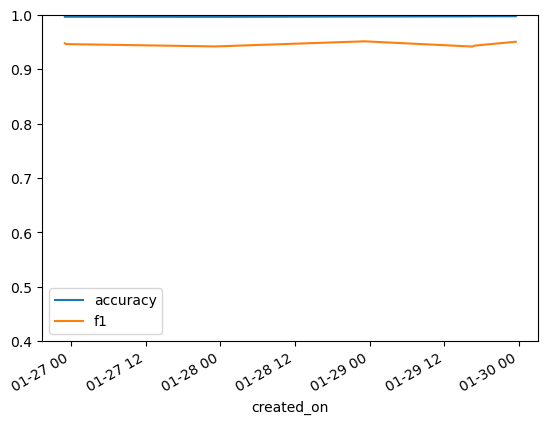

In [42]:
import json

rpd = res.to_pandas()[["created_on", "metadata"]] #.select(functions.col("metadata")).show()
rpd = rpd.loc[rpd['metadata'] != '{}']
rpd['accuracy'] = rpd['metadata'].apply(json.loads).apply(lambda x: x['metrics']['accuracy'])
rpd['f1'] = rpd['metadata'].apply(json.loads).apply(lambda x: x['metrics']['f1'])
ax = rpd.plot(x='created_on', y=['accuracy', 'f1'])
ax.set_ylim(0.4, 1.0)
#metrics = res.flatten(res['"metadata"'])
#metrics.show()
rpd